In [1]:
# imports
import gym
import numpy as np
import math
import matplotlib.pyplot as plt

In [38]:
# chakra environment

from gym import Env
from gym.envs.registration import register
from gym.utils import seeding
from gym import spaces
import numpy as np


class chakra(Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self,mode):
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = spaces.Box(low=-1, high=1, shape=(2,))
        self.mode = mode
        self._seed()
        self.viewer = None
        self.state = None

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        pos = self.state
#         print(pos,action)
        new_pos = pos + action
#         print(new_pos)
        if(self.mode == 'chakra'):
            xx = 0.025
            rwd = np.sqrt(new_pos[0]*new_pos[0]+new_pos[1]*new_pos[1])
            old_rwd = np.sqrt(pow(pos[0],2)+pow(pos[1],2))
        elif(self.mode == 'vishamC'):
            xx = 0.01
            rwd = 0.5*new_pos[0]*new_pos[0]+5*new_pos[1]*new_pos[1]
            old_rwd = 0.5*pow(pos[0],2)+5*pow(pos[1],2)
        fin = -rwd
        if(new_pos[0] > 1 or new_pos[1] > 1 or new_pos[0] < -1 or new_pos[1] < -1):
            new_pos = self._reset()
            self.state = new_pos
            return new_pos,fin,False,{}
        elif((rwd < xx)or(new_pos[0] == 0 and new_pos[1] == 0)):
            return new_pos,0,True,{}
        else:
            self.state = new_pos
            return new_pos,fin,False,{}
    # Return the next state and the reward, along with 2 additional quantities : False, {}

    def _reset(self):
        while True:
            self.state = self.np_random.uniform(low=-1, high=1, size=(2,))
            # Sample states that are far away
            if np.linalg.norm(self.state) > 0.9:
                break
        return np.array(self.state)

    # method for rendering

    def _render(self, mode='human', close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        screen_width = 800
        screen_height = 800

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)

            agent = rendering.make_circle(
                min(screen_height, screen_width) * 0.03)
            origin = rendering.make_circle(
                min(screen_height, screen_width) * 0.03)
            trans = rendering.Transform(translation=(0, 0))
            agent.add_attr(trans)
            self.trans = trans
            agent.set_color(1, 0, 0)
            origin.set_color(0, 0, 0)
            origin.add_attr(rendering.Transform(
                translation=(screen_width // 2, screen_height // 2)))
            self.viewer.add_geom(agent)
            self.viewer.add_geom(origin)

        # self.trans.set_translation(0, 0)
        self.trans.set_translation(
            (self.state[0] + 1) / 2 * screen_width,
            (self.state[1] + 1) / 2 * screen_height,
        )

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

In [ ]:
# roll out

def include_bias(pp):
    return (1,pp[0],pp[1])
    

def chakra_get_action(theta, ob, rng=np.random):
    ob_1 = include_bias(ob)
    mean = theta.dot(ob_1)
    return rng.normal(loc=mean, scale=1.)

# Register the environment
rng = np.random.RandomState(42)
    
env = chakra()

get_action = chakra_get_action
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

env.seed(42)

# Initialize parameters
theta = rng.normal(scale=0.01, size=(action_dim, obs_dim + 1))

# while True:
#     ob = env._reset()
#     done = False
#     # Only render the first trajectory
#     # Collect a new trajectory
# one run
ob = env._reset()
done = False
rewards = []
while not done:
    action = get_action(theta, ob, rng=rng)
    next_ob, rew, done, _ = env._step(action)
    ob = next_ob
    env._render()
    rewards.append(rew)
print("Episode reward: %.2f" % np.sum(rewards))

In [35]:
# Policy Gradient Functions

def get_mu_ss(theta,state):
    ss = np.transpose([[1,state[0],state[1]]])
    mu = np.matmul(np.transpose(theta),ss)
    return mu,ss

def take_act(theta,state,clip,rng=np.random):
    mu,ss = get_mu_ss(theta,state)
    action = rng.normal(loc=mu, scale=1.)
    if(np.linalg.norm(action)>clip):
        action = (action/np.linalg.norm(action))*clip
    return action
    

def log_pi(action,state,theta):
    mu,ss = get_mu_ss(theta,state)
    mat = np.matmul(np.transpose(action-mu),action-mu)[0]
    val = -1*math.log(2*math.pi) - 0.5*mat
    return val

def diff_log_pi(action,state,theta):
    mu,ss = get_mu_ss(theta,state)
    var = action-mu
    return np.matmul((ss),np.transpose(var))

def take_right_act(theta,state,clip):
    mu,ss = get_mu_ss(theta,state)
    action = mu
    if(np.linalg.norm(action)>clip):
        action = (action/np.linalg.norm(action))*clip
    return action
    
def base_val(state):
    # write it
    return 0


In [39]:
# policy gradient algo.

max_iter = 20
batch_size = 10
step_limit = 10000
ALPHA = 0.05
GAMMA = 0.99

envP = chakra('vishamC')
envP.seed(42)

obs_dim = envP.observation_space.shape[0]
action_dim = envP.action_space.shape[0]
rng = np.random.RandomState(42)
theta = rng.normal(scale=0.01, size=(obs_dim + 1,action_dim))


ep_rwd = []
ep_sts = []

for itr in range(max_iter):
    # collect trajectory and store cum. returns
    ep_itr_rwd = []
    ep_itr_sts = []
    n_samp_grad = 0
    for n_samples in range(batch_size):
        # new trajectory
        done = False
        ob = envP._reset()
        rewards = []
        acts = []
        stats = []
        
        tot = 0
        sts = 0
        for i in range(step_limit):
            action = take_act(theta,ob,0.025,rng)
            next_ob, rwd, done, _ = envP._step(action.flatten())
            # envP._render()
            rewards.append(rwd)
            tot += rwd
            acts.append(action)
            stats.append(ob)
            ob = next_ob
            sts += 1
            if(done):
                break
        print(tot,sts)
        ep_itr_sts.append(sts)
        ep_itr_rwd.append(tot)
        T = len(acts) - 1
        grad = 0
        for t in range(T + 1):
            Rt = 0
            ii = 1
            for u in range(t,T+1):
                Rt += (ii*rewards[u])
                ii = ii*GAMMA
            At = Rt - base_val(stats[t])
            grad += (diff_log_pi(acts[t],stats[t],theta)*At)
        grad = grad / (np.linalg.norm(grad) + 1e-8)
        
        n_samp_grad += (grad)
    
    ep_rwd.append(ep_itr_rwd)
    ep_sts.append(ep_itr_sts)
    theta = theta + (ALPHA/batch_size)*n_samp_grad
    print("iteration:"+str(itr))
    print("Avg rwd:"+str(np.mean(ep_itr_rwd)))
    print("Num steps:"+str(np.mean(ep_itr_sts)))
    print("theta:")
    print(theta)      

-14529.897412867262 7153
-6929.589840273994 3512
-4942.903800077062 2924
-6531.412728013138 4105
-1829.3078027554366 1286
-11485.640011263442 6593
-21771.35318214648 10000
-10776.049676967383 10000
-23229.474143422613 10000
-11364.906956300223 6400
iteration:0
Avg rwd:-11339.053555408706
Num steps:6197.3
theta:
[[ 0.02738058 -0.01758731]
 [ 0.01533258  0.04395422]
 [-0.00635626 -0.00452821]]
-497.1243273835009 617
-3101.067088150963 2166
-14659.122240219865 5983
-1196.1527730267346 880
-19075.49339543924 7573
-12528.164562895923 5751
-2293.6202607367495 1644
-2467.965934978277 1371
-968.5820698031173 1128
-235.1914468765188 544
iteration:1
Avg rwd:-5702.248409951089
Num steps:2765.7
theta:
[[ 0.05632811 -0.04265125]
 [ 0.01955966  0.06741977]
 [-0.00770123 -0.00424407]]
-20041.82528797745 10000
-16310.17502225355 7179
-5393.4206530744395 3918
-3513.2126180022724 4240
-1337.7048912858684 1059
-19875.130465492126 10000
-9766.99786732309 5640
-1860.232107772044 839
-12312.204528866558 642

In [12]:
theta_op = [[ 1.82013926 ,-0.8078604 ],
 [ 0.34450036 , 0.35901687],
 [-0.13823325, -0.0095666 ]]
#[[0 ,0],[-1,0],[0,-1]]

In [69]:
done = False
tot = 0
sts = 0
ob = envP._reset()
post = [ob]
while(not done):
        action = take_right_act(theta,ob,0.025)
        next_ob, rwd, done, _ = envP._step(action.flatten())
        #envP._render()
        tot += rwd
        sts += 1
        ob = next_ob
        post.append(ob)
print(tot,sts)

-306.31529696509295 183


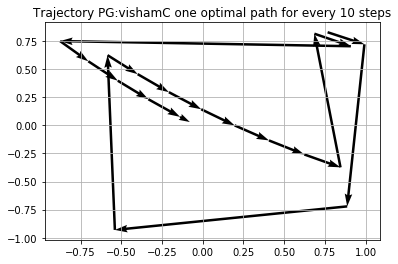

In [70]:
jump = 10
p = jump
prev = post[0]
plt.title("Trajectory PG:vishamC one optimal path for every 10 steps")
plt.grid(True)
while(p < len(post)):
    pres = post[p]
    plt.quiver(prev[0],prev[1],pres[0]-prev[0],pres[1]-prev[1],angles='xy',scale_units='xy',scale=1.)
    prev = pres
    p += jump
pres = post[-1]
plt.quiver(prev[0],prev[1],pres[0]-prev[0],pres[1]-prev[1],angles='xy',scale_units='xy',scale=1.)
plt.show()

In [74]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
pol = PolynomialFeatures(degree=2)

V = {}
step_limit = 10000
for j in range(10):
    rewards = []
    stats = []
    acts = []
    ob = envP._reset()
    for i in range(step_limit):
        action = take_right_act(theta,ob,0.025)
        next_ob, rwd, done, _ = envP._step(action.flatten())
        rewards.append(rwd)
        acts.append(action)
        stats.append(ob)
        ob = next_ob
        #print(ob)
        if(done):
            break
    print(len(stats))
    T = len(acts) - 1
    for t in range(T + 1):
        Rt = 0
        ii = 1
        for u in range(t,T+1):
            Rt += (ii*rewards[u])
            ii = ii*GAMMA
        V[stats[t][0],stats[t][1]] = Rt


1144
354
500
357
710
2834
147
51
154
45


In [75]:
X = [[a[0],a[1]]for a,b in V.items()]
y = [[b]for a,b in V.items()]
X = pol.fit_transform(X)
clf = linear_model.LinearRegression()
clf.fit(X,y)
co = clf.coef_

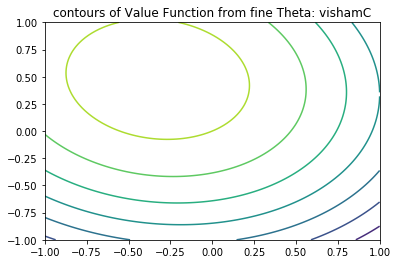

In [76]:
xlist = np.linspace(-1, 1, 100)
ylist = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(xlist, ylist)

Z = co[0][0] + co[0][1]*X + co[0][2]*Y + co[0][3]*X*Y + co[0][4]*X*X + co[0][5]*Y*Y
plt.title('contours of Value Function from fine Theta: vishamC')
plt.contour(X,Y,Z)